In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#store the path of the drug-metabolite file
path = 'C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\Datasets\\tolylquinone_integrated.csv'

In [4]:
#extract the name of the drug

dr = path.split('\\')[-1]
drug_name = dr.split('_')[0]
drug_name

'tolylquinone'

In [5]:
#read the input drug-metabolite integrated data
data = pd.read_csv(path)

In [6]:
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,1.93205,3.74886,0.452336,0.940899,2.78817,0.493042,1.21729,36.0483,2.49718,2.30652
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,1.96807,3.22352,0.157620,0.343406,2.11181,0.135277,1.42039,103.5290,1.27063,1.64715


In [7]:
#drop the target drug column
drug = data.pop(f'{drug_name}')

In [8]:
#read the representative set of metabolites

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()
    
#read the genes

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\list_of_genes.txt', 'r+') as f:
     rep_genes = f.read().strip().splitlines()   
     
rep_genes.extend(rep_meta)

In [10]:
len(rep_meta), len(rep_genes)

(197, 24023)

In [11]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites and the gene expression profiles
X = X[rep_genes]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [12]:
X.shape

(52, 24023)

In [13]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [14]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [15]:
X.shape, y.shape

((52, 24023), (52,))

In [16]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

1    33
0    19
dtype: int64

In [17]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [18]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.701622,0.990098,0.024082,-0.096043,-0.083851,0.037473,0.061888,0.055409,2.287621,0.263113,...,-1.156232,-0.984780,-0.459775,-1.079063,0.704345,-1.216094,-0.533222,0.311697,-0.739809,1.201711
1,2.200088,0.185537,-0.203710,-0.313315,-0.083851,-0.185301,0.061888,0.055409,-1.039432,4.938505,...,-0.778831,-0.140916,-1.197691,-0.050216,-0.929811,-1.073083,-1.189294,-2.131159,-1.581728,0.818424


In [19]:
X.shape, y.shape

((66, 24023), (66,))

In [20]:
y.value_counts()

0    33
1    33
dtype: int64

In [21]:
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.701622,0.990098,0.024082,-0.096043,-0.083851,0.037473,0.061888,0.055409,2.287621,0.263113,...,-1.156232,-0.984780,-0.459775,-1.079063,0.704345,-1.216094,-0.533222,0.311697,-0.739809,1.201711
1,2.200088,0.185537,-0.203710,-0.313315,-0.083851,-0.185301,0.061888,0.055409,-1.039432,4.938505,...,-0.778831,-0.140916,-1.197691,-0.050216,-0.929811,-1.073083,-1.189294,-2.131159,-1.581728,0.818424


In [22]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [23]:
X_train.shape, X_test.shape

((52, 24023), (14, 24023))

In [24]:
y_train.value_counts(), y_test.value_counts()

(0    27
 1    25
 dtype: int64,
 1    8
 0    6
 dtype: int64)

In [25]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 609
Number of features selected during iteration 1: 611
Number of features selected during iteration 2: 604
Number of features selected during iteration 3: 599
Number of features selected during iteration 4: 607
Number of features selected during iteration 5: 607
Number of features selected during iteration 6: 594
Number of features selected during iteration 7: 595
Number of features selected during iteration 8: 608
Number of features selected during iteration 9: 615
Number of features selected during iteration 10: 630
Number of features selected during iteration 11: 593
Number of features selected during iteration 12: 616
Number of features selected during iteration 13: 597
Number of features selected during iteration 14: 617
Number of features selected during iteration 15: 592
Number of features selected during iteration 16: 616
Number of features selected during iteration 17: 606
Number of features selected during iteration 18: 612
Num

In [26]:
features = list(X_train_new.columns)
count = 0
for i in features:
    if i in rep_meta:
        count+=1 #get the number of metabolites selected from the represented features
count, len(features) - count #count the number of genes 

(16, 617)

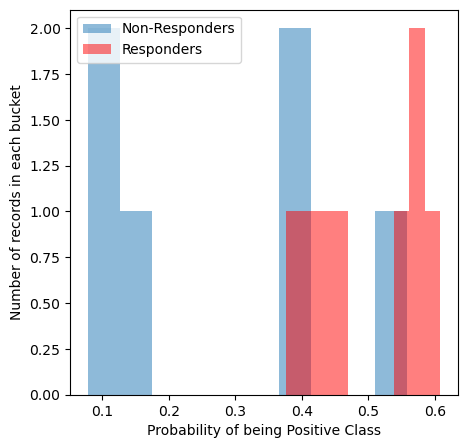

In [27]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [28]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [29]:
df1

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.701622,0.990098,0.024082,-0.096043,-0.083851,0.037473,0.061888,0.055409,2.287621,0.263113,...,-0.459775,-1.079063,0.704345,-1.216094,-0.533222,0.311697,-0.739809,1.201711,NaN,NaN
1,2.200088,0.185537,-0.203710,-0.313315,-0.083851,-0.185301,0.061888,0.055409,-1.039432,4.938505,...,-1.197691,-0.050216,-0.929811,-1.073083,-1.189294,-2.131159,-1.581728,0.818424,NaN,NaN
2,-0.535120,-0.935111,-0.297655,-0.314077,-0.083851,-0.335081,0.061888,-0.550627,-1.128690,0.263113,...,-0.016333,-0.954659,-0.199550,-1.099483,-0.398669,-0.551806,-0.630156,-0.163950,NaN,NaN
3,2.538594,0.700586,-0.320871,-0.314573,-0.494718,0.037473,0.061888,-0.354637,-0.809290,0.263113,...,-0.188922,-0.312571,0.247798,0.241364,-0.484360,-0.826676,0.479003,-0.767456,NaN,NaN
4,1.604367,-0.879103,0.024082,-0.312847,-0.083851,0.037473,0.061888,-0.259219,-1.053395,0.110207,...,-1.286698,0.173271,-1.602744,1.181061,-2.066637,-0.665104,-1.124433,-0.010430,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,-0.319429,0.241178,-0.275838,-0.198719,-0.273502,-0.138796,0.061888,-0.195131,0.216063,-0.515235,...,1.424353,0.383992,1.028165,0.747015,1.101813,0.864788,1.267915,-0.142322,NaN,NaN
62,-0.437400,0.159322,-0.175644,-0.313285,-0.295755,-0.326962,0.061888,0.055409,0.695394,-0.169733,...,-0.212900,-0.611977,-0.266722,-0.959222,-0.060241,-0.055058,-0.615973,0.074547,NaN,NaN
63,-0.754553,-0.891599,-0.164992,-0.313316,-0.177630,-0.320649,0.061888,-0.570828,-0.542629,-1.368535,...,2.081368,1.061761,2.365674,0.065454,1.998346,1.985304,2.445886,0.612294,NaN,NaN
64,-0.565859,-0.901858,0.024082,-0.308225,-0.377581,0.037473,0.061888,0.055409,-0.972966,0.263113,...,0.625348,0.739729,0.108162,-0.084212,1.114844,0.012041,0.283334,-0.810458,NaN,NaN


In [30]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(4, 24025)

In [31]:
df1_main.index.values #0 40 41 42

array([ 5, 19, 33, 40], dtype=int64)

In [32]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 615
Features selected during iteration 1: 600
Features selected during iteration 2: 621
Features selected during iteration 3: 611
Features selected during iteration 4: 616
Features selected during iteration 5: 622
Features selected during iteration 6: 624
Features selected during iteration 7: 597
Features selected during iteration 8: 614
Features selected during iteration 9: 615
Features selected during iteration 10: 615
Features selected during iteration 11: 612
Features selected during iteration 12: 613
Features selected during iteration 13: 601
Features selected during iteration 14: 600
Features selected during iteration 15: 608
Features selected during iteration 16: 590
Features selected during iteration 17: 620
Features selected during iteration 18: 606
Features selected during iteration 19: 609
Features selected during iteration 20: 615
Features selected during iteration 21: 620
Features selected during iteration 22: 613
Features selected dur

In [33]:
print(f'Average number of features being selected: {np.mean(num_features2)}')

Average number of features being selected: 610.18


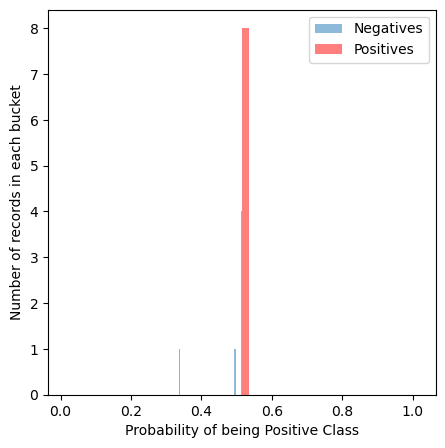

In [34]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [35]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [36]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target


In [37]:
df2_main.index.values #40 41 42

array([], dtype=int64)

In [38]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 26
Features selected during iteration 1: 26
Features selected during iteration 2: 26
Features selected during iteration 3: 26
Features selected during iteration 4: 26
Features selected during iteration 5: 26
Features selected during iteration 6: 26
Features selected during iteration 7: 26
Features selected during iteration 8: 26
Features selected during iteration 9: 26
Features selected during iteration 10: 26
Features selected during iteration 11: 26
Features selected during iteration 12: 26
Features selected during iteration 13: 26
Features selected during iteration 14: 26
Features selected during iteration 15: 26
Features selected during iteration 16: 26
Features selected during iteration 17: 26
Features selected during iteration 18: 26
Features selected during iteration 19: 26
Features selected during iteration 20: 26
Features selected during iteration 21: 26
Features selected during iteration 22: 26
Features selected during iteration 23: 26
Fe

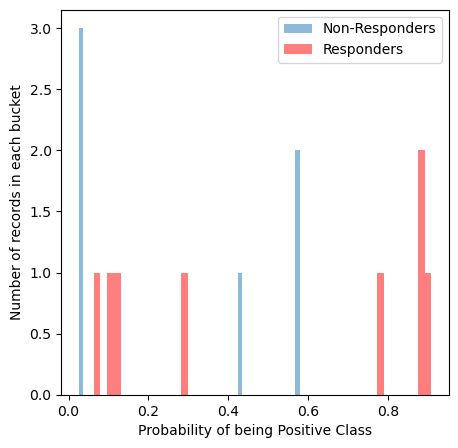

In [39]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [40]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.701622,0.990098,0.024082,-0.096043,-0.083851,0.037473,0.061888,0.055409,2.287621,0.263113,...,-0.459775,-1.079063,0.704345,-1.216094,-0.533222,0.311697,-0.739809,1.201711,NaN,NaN
1,2.200088,0.185537,-0.203710,-0.313315,-0.083851,-0.185301,0.061888,0.055409,-1.039432,4.938505,...,-1.197691,-0.050216,-0.929811,-1.073083,-1.189294,-2.131159,-1.581728,0.818424,NaN,NaN
2,-0.535120,-0.935111,-0.297655,-0.314077,-0.083851,-0.335081,0.061888,-0.550627,-1.128690,0.263113,...,-0.016333,-0.954659,-0.199550,-1.099483,-0.398669,-0.551806,-0.630156,-0.163950,NaN,NaN
3,2.538594,0.700586,-0.320871,-0.314573,-0.494718,0.037473,0.061888,-0.354637,-0.809290,0.263113,...,-0.188922,-0.312571,0.247798,0.241364,-0.484360,-0.826676,0.479003,-0.767456,NaN,NaN
4,1.604367,-0.879103,0.024082,-0.312847,-0.083851,0.037473,0.061888,-0.259219,-1.053395,0.110207,...,-1.286698,0.173271,-1.602744,1.181061,-2.066637,-0.665104,-1.124433,-0.010430,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,-0.319429,0.241178,-0.275838,-0.198719,-0.273502,-0.138796,0.061888,-0.195131,0.216063,-0.515235,...,1.424353,0.383992,1.028165,0.747015,1.101813,0.864788,1.267915,-0.142322,NaN,NaN
62,-0.437400,0.159322,-0.175644,-0.313285,-0.295755,-0.326962,0.061888,0.055409,0.695394,-0.169733,...,-0.212900,-0.611977,-0.266722,-0.959222,-0.060241,-0.055058,-0.615973,0.074547,NaN,NaN
63,-0.754553,-0.891599,-0.164992,-0.313316,-0.177630,-0.320649,0.061888,-0.570828,-0.542629,-1.368535,...,2.081368,1.061761,2.365674,0.065454,1.998346,1.985304,2.445886,0.612294,NaN,NaN
64,-0.565859,-0.901858,0.024082,-0.308225,-0.377581,0.037473,0.061888,0.055409,-0.972966,0.263113,...,0.625348,0.739729,0.108162,-0.084212,1.114844,0.012041,0.283334,-0.810458,NaN,NaN


In [41]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
5,1.021139,1.169511,-0.303294,-0.314235,-0.083851,0.037473,0.061888,-0.537333,-1.005106,0.263113,...,-0.480022,0.380179,-0.009215,0.722489,-1.466482,1.068706,0.514420,-1.035905,0.877577,1.0
14,-0.589162,0.041422,-0.302313,-0.314472,-0.083851,0.037473,0.061888,-0.471050,0.403948,0.263113,...,-0.123431,0.748992,1.141898,0.812434,0.718204,0.366826,0.601918,0.286382,0.783933,1.0
33,0.049960,-0.494120,0.024082,-0.045735,-0.366426,-0.314141,0.061888,-0.376232,-1.224623,0.263113,...,-0.853569,-0.339417,0.335163,1.854317,0.274166,-0.266796,-0.180692,-0.065950,0.890251,1.0
43,-0.857238,-0.939513,0.284668,-0.312495,-0.349757,0.037473,0.061888,0.055409,-0.918438,0.263113,...,2.177710,0.424247,1.261797,-0.550783,-0.518776,1.834168,1.044409,-0.155249,0.909037,1.0


In [42]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [43]:
cl = set(common_list)
cl

{5, 14, 19, 33, 40, 43}

In [44]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
5,1.021139,1.169511,-0.303294,-0.314235,-0.083851,0.037473,0.061888,-0.537333,-1.005106,0.263113,...,-0.480022,0.380179,-0.009215,0.722489,-1.466482,1.068706,0.514420,-1.035905,0.571600,1.0
14,-0.589162,0.041422,-0.302313,-0.314472,-0.083851,0.037473,0.061888,-0.471050,0.403948,0.263113,...,-0.123431,0.748992,1.141898,0.812434,0.718204,0.366826,0.601918,0.286382,0.466400,1.0
18,-0.494616,-0.490377,-0.281125,-0.281819,0.302501,0.037473,0.061888,-0.430459,-0.042530,0.263113,...,-1.047314,-0.050216,-0.426362,-2.351557,-2.101767,-1.389948,-0.601032,-0.615288,0.404400,1.0
19,-0.528507,-0.292554,-0.311832,-0.313132,-0.083851,0.037473,0.061888,0.055409,-0.201610,0.263113,...,-0.545367,0.010168,-0.019388,1.012818,-0.252575,-0.392562,-0.913909,1.403108,0.565733,1.0
22,-0.449173,-0.443160,0.024082,-0.283391,-0.044707,0.037473,0.061888,0.055409,-0.431569,0.263113,...,-1.538459,1.605912,-1.075740,1.252902,-0.830727,-1.221119,-1.776748,-0.575074,0.376400,1.0
33,0.049960,-0.494120,0.024082,-0.045735,-0.366426,-0.314141,0.061888,-0.376232,-1.224623,0.263113,...,-0.853569,-0.339417,0.335163,1.854317,0.274166,-0.266796,-0.180692,-0.065950,0.558800,1.0
40,0.151483,0.577755,0.024082,-0.096043,-0.083851,0.037473,0.061888,0.055409,-0.735608,0.263113,...,1.896495,0.698957,0.832393,-0.571700,-0.497870,1.923069,1.684192,-0.212174,0.608133,1.0
43,-0.857238,-0.939513,0.284668,-0.312495,-0.349757,0.037473,0.061888,0.055409,-0.918438,0.263113,...,2.177710,0.424247,1.261797,-0.550783,-0.518776,1.834168,1.044409,-0.155249,0.423067,1.0


In [45]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\outputs\\master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [46]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\outputs\\total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')